In [61]:
import numpy as np                  # numpy, model for data manipulation  
import pandas as pd                 # pandas, model for data manipulation
import os, random                   # os, model for operating system
import matplotlib.pyplot as plt     # matplotlib, model for data visualization
import seaborn as sns               # seaborn, model for data visualization
import tensorflow as tf             # tensorflow, model knowed for deep learning
import keras                        # keras, model knowed for deep learning

# other keras imports
from keras.preprocessing import image   # image, model for image processing
from keras.models import Sequential     # Sequential, model for deep learning
# keras layers
from keras.layers import  Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input                               
from keras.preprocessing.image import ImageDataGenerator # ImageDataGenerator, model for image processing
from keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception  # VGG16, InceptionResNetV2, RESNet model for deep learning    
from keras import regularizers                           # regularizers, model for deep learning
from keras.optimizers import Adam,RMSprop,SGD,Adamax     # Adam,RMSprop,SGD,Adamax, model for deep learning
from keras.models import Model                           # Model, model for deep learning
from keras import layers                                 # layers, model for deep learning
from keras.callbacks import ReduceLROnPlateau, EarlyStopping # ReduceLROnPlateau, EarlyStopping, model for deep learning
from keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [62]:
# count number of files in a directory
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

train_folder = '/Users/hugopereira/DatasetMEIA/train'
test_folder = '/Users/hugopereira/DatasetMEIA/test'

SkinDisease_train = dict()
SkinDisease_test = dict()

for dir in os.listdir(train_folder):
    if dir != ".DS_Store":
        print('Total number of images in the [', dir.upper() ,'] : ', count_files(os.path.join(train_folder, dir)))
        SkinDisease_train[dir] = count_files(os.path.join(train_folder, dir))

for dir in os.listdir(test_folder):
    if dir != ".DS_Store":
        print('Total number of images in the [', dir.upper() ,'] : ', count_files(os.path.join(test_folder, dir)))
        SkinDisease_test[dir] = count_files(os.path.join(test_folder, dir))

print('Total number of images in the [TRAIN DATASET] :', sum(SkinDisease_train.values()))
print('Total number of images in the [TEST DATASET] :', sum(SkinDisease_test.values()))

Total number of images in the [ URTICARIA HIVES ] :  212
Total number of images in the [ PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES ] :  1405
Total number of images in the [ LUPUS AND OTHER CONNECTIVE TISSUE DISEASES ] :  420
Total number of images in the [ ATOPIC DERMATITIS PHOTOS ] :  489
Total number of images in the [ MELANOMA SKIN CANCER NEVI AND MOLES ] :  463
Total number of images in the [ URTICARIA HIVES ] :  53
Total number of images in the [ PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES ] :  352
Total number of images in the [ LUPUS AND OTHER CONNECTIVE TISSUE DISEASES ] :  105
Total number of images in the [ ATOPIC DERMATITIS PHOTOS ] :  123
Total number of images in the [ MELANOMA SKIN CANCER NEVI AND MOLES ] :  116
Total number of images in the [TRAIN DATASET] : 2989
Total number of images in the [TEST DATASET] : 749


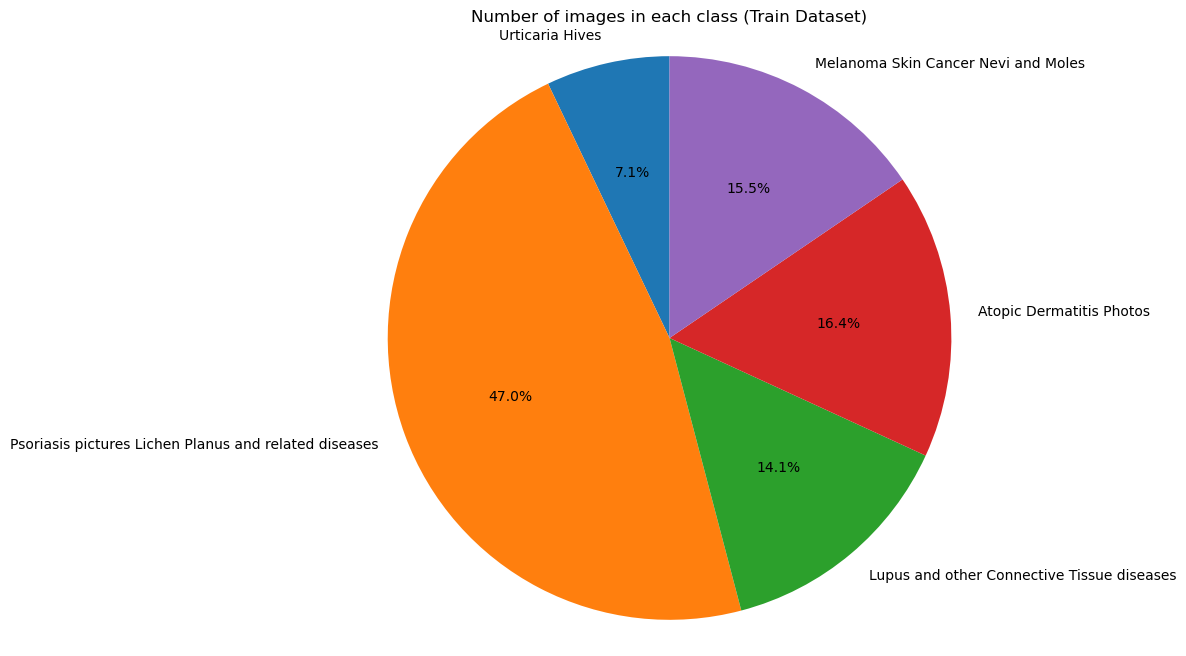

In [63]:
#Plot the number of images in each class using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(SkinDisease_train.values(), labels=SkinDisease_train.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train Dataset)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [122]:
# Modelo
# Get data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_data(train_folder, test_folder):
    # Load the images from the train and test folders into train and test sets using ImageDataGenerator
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(SIZE, SIZE),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(SIZE, SIZE),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        seed=10
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(SIZE, SIZE),
        batch_size=32,
        class_mode='categorical',
        seed=10
    )

    return train_generator, validation_generator, test_generator

In [123]:
# Get Model
def get_model(model_list, model_name, weights=None):
    # Instantiate the model
    model = model_list[model_name](weights)

    # Summary of the model
    model.summary()

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )

    return model

In [124]:
# Train Model
#Function to train model
#model = model to train
#train_generator = train data
#validation_generator = validation data
#epochs = number of epochs to train

# Train Model
def train_model(model, train_generator, validation_generator, epochs, model_name):
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy'),
        tf.keras.callbacks.ModelCheckpoint(save_best_only=True, monitor='val_accuracy', filepath='Best_Model/' + model_name + '.h5'),
    ]

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
    )

    return model, history

In [125]:
# Evaluate Model
#Function to evaluate model
#history = history of the model

def evaluate_model(history):

    #Plot the training and validation accuracy and loss at each epoch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
     #Plot training and validation metrics of the model
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.legend()

    return plt

In [126]:
# Save Model

#Function to save model
#model = model to save
#model_name = model name to save
#history = history of the model

# Evaluate model function (assuming it's defined elsewhere)
def evaluate_model(history):
    # Your evaluation code here
    pass

# Save Model
def save_model(model, model_name, history):
    # Create a folder to save models if it does not exist
    if not os.path.exists('Saved_Models'):
        os.mkdir('Saved_Models')
    
    # Create a folder to save the model if it does not exist
    if not os.path.exists('Saved_Models/' + model_name):
        os.mkdir('Saved_Models/' + model_name)
    
    # Save the model
    model.save('Saved_Models/' + model_name + '/' + model_name + '.h5')

    # Save the evaluation of model
    plt = evaluate_model(history)
    plt.savefig('Saved_Models/' + model_name + '/' + model_name + '_evaluation.png')

    # Save the model architecture
    tf.keras.utils.plot_model(
        model,
        to_file='Saved_Models/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Save the model history into a csv 
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Saved_Models/' + model_name + '/' + model_name + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [127]:
# Run Model

#Function to load Model
#model_list = models list available
#path_folder = path to load model
#model_name = model name to load
def Run_Model(model_list, train_folder, test_folder, model_name, weights=None):
    # Get data
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Get model
    model = get_model(model_list, model_name, weights)
    
    # Train model
    model, history = train_model(model, train_generator, validation_generator, epochs=50, model_name=model_name)
    
    # Evaluate model
    evaluate_model(history)
    
    # Save model
    save_model(model, model_name, history)
    
    return model

In [128]:
SIZE = 250

In [129]:
INPUT_SHAPE = (SIZE, SIZE, 3) 

In [130]:
# CNN
#Function of architecture of CNN model
def CNN_model(weights=None):
    # Create a CNN model
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Global Average Pooling Layer
    model.add(GlobalAveragePooling2D())

    # Output Layer
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=5, activation='softmax'))

    return model  

In [137]:
# VGG16
#Function of architecture of VGG16 model
def VGG16_model(weights=None):
    # Create a VGG16 model
    model = Sequential()

    # Input Layer
    input_layer = Input(shape=(SIZE, SIZE, 3))

    # Importing VGG16 from keras API
    vgg_base = VGG16(include_top=False, weights=weights, input_tensor=input_layer)

    # Output Layer
    x = Flatten()(vgg_base.output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output_layer = Dense(units=5, activation='softmax')(x)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [140]:
# RestNet
#Function of architecture of RESNet model
def RESNet_model(weights=None):
    # Create a ResNet50 model
    model = Sequential()

    # Input Layer
    input_layer = Input(shape=(SIZE, SIZE, 3))

    # Importing ResNet50 from keras API
    resnet_base = ResNet50(include_top=False, weights=weights, input_tensor=input_layer)

    # Output Layer
    x = Flatten()(resnet_base.output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output_layer = Dense(units=5, activation='softmax')(x)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [141]:
# List of Models
# List off available Models - defined above
model_list = { 
    "CNN_model":CNN_model , 
    "VGG16_model" : VGG16_model ,
    "RESNet_model" : RESNet_model ,
}

In [134]:
# Run CNN
# Path to the training and testing dataset folders
train_folder = '/Users/hugopereira/DatasetMEIA/train'
test_folder = '/Users/hugopereira/DatasetMEIA/test'

# Run the CNN model
model_name = 'CNN_model'  # Name of the model to run
model = Run_Model(model_list, train_folder, test_folder, model_name)


Found 2393 images belonging to 5 classes.
Found 596 images belonging to 5 classes.
Found 749 images belonging to 5 classes.
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 250, 250, 256)     7168      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 125, 125, 256)    0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 125, 125, 256)     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                        

2024-03-19 20:03:44.265260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 4/75 [>.............................] - ETA: 5:12 - loss: 1.3640 - accuracy: 0.4531 - precision_7: 0.7037 - recall_7: 0.1484 - auc_7: 0.7608        

KeyboardInterrupt: 

In [139]:
# Run VGG16
# Path to the training and testing dataset folders
train_folder = '/Users/hugopereira/DatasetMEIA/train'
test_folder = '/Users/hugopereira/DatasetMEIA/test'

# Run ResNet model without weights
Run_Model(model_list, train_folder, test_folder, "VGG16_model", weights=None)

# Run ResNet model with pre-trained weights
Run_Model(model_list, train_folder, test_folder, "VGG16_model", weights='imagenet')


Found 2393 images belonging to 5 classes.
Found 596 images belonging to 5 classes.
Found 749 images belonging to 5 classes.
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
 

2024-03-19 20:06:30.369501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/75 [..............................] - ETA: 15:01 - loss: 1.6093 - accuracy: 0.1875 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - auc_10: 0.5000

KeyboardInterrupt: 

In [142]:
# Run ResNet
# Path to the training and testing dataset folders
train_folder = '/Users/hugopereira/DatasetMEIA/train'
test_folder = '/Users/hugopereira/DatasetMEIA/test'

# Run ResNet model without weights
Run_Model(model_list, train_folder, test_folder, "RESNet_model", weights=None)

# Run ResNet model with pre-trained weights
Run_Model(model_list, train_folder, test_folder, "RESNet_model", weights='imagenet')

Found 2393 images belonging to 5 classes.
Found 596 images belonging to 5 classes.
Found 749 images belonging to 5 classes.
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                  

2024-03-19 20:08:16.905280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 4/75 [>.............................] - ETA: 5:49 - loss: 119.9645 - accuracy: 0.2266 - precision_11: 0.2353 - recall_11: 0.2188 - auc_11: 0.5072

KeyboardInterrupt: 

In [27]:
# Save the models in a zip file -- use this in colab to download the models
#!zip -r /content/saved_models.zip /content/saved_models

In [28]:
#Confusion Matrix
#Load model
model = tf.keras.models.load_model('../Saved_Models/CNN_model/CNN_model.h5')

_, validation_generator = get_data(DatasetPath)

y_pred = model.predict(validation_generator)

import sklearn.metrics as metrics

#Get the confusion matrix
cm = metrics.confusion_matrix(validation_generator.classes, np.argmax(y_pred, axis=1))

#Plot the confusion matrix
plt.figure(figsize=(5,5))

sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);

OSError: No file or directory found at ../Saved_Models/CNN_model/CNN_model.h5

In [29]:
validation_generator.class_indices

NameError: name 'validation_generator' is not defined